<h1>Jobs analysis project</h1>
This is a project where I built a data pipeline, continuously collecting new data on data science, engineering, and analytics jobs from monster.com, then perform analyses and visualizations on how various aspects of the collected data affect salaries in the field. The focus of the project is on the pipeline itself, with the other aspects primarily being there to give the pipeline something to do. I used Julia for the entire pipeline. I used the Gumbo and Cascadia Julia libraries for web scraping, and collected and organized the data into a SQLite database.

In [1]:
using DataFrames
using SQLite
using CSV
using PyCall
using Plots
using Images
using ScikitLearn
@sk_import linear_model: (Ridge, Lasso)
import Base: transpose
const DATA_DIR = ".\\data\\cleaned"

".\\data\\cleaned"

In [49]:
PICTURE_LENGTH = 3148
PICTURE_HEIGHT = 1718

NORTH = 49.23041 #northernmost point in the contiguous 48 states
SOUTH = 26.268   #southernmost point in the contiguous 48 states
EAST = -66.59592 #easternmost point in the contiguous 48 states
WEST = -127.471  #westernmost point in the contiguous 48 states

-127.471

In [50]:
db = SQLite.DB("$(DATA_DIR)\\jobs.db")

SQLite.DB(".\data\cleaned\jobs.db")

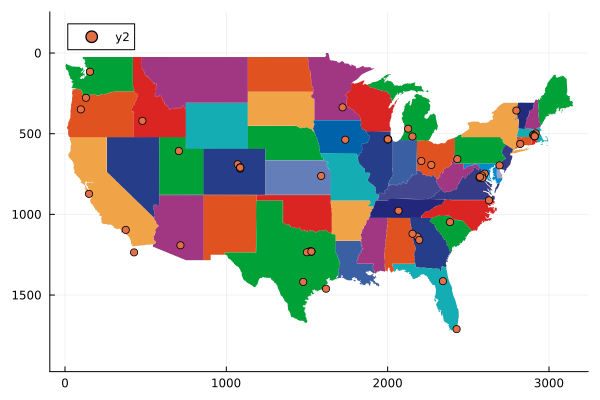

In [59]:
#analyze/create visualizations for geo data (put in function to avoid global variables)

function normalize(measure, bottom, top, new_top)
    difference = top - bottom
    measure -= bottom
    measure /= difference
    measure * new_top
end

#
function shift_normalize(position)
    shift_amount = (PICTURE_LENGTH - position)^1.005 - (PICTURE_LENGTH - position)
    position - shift_amount
end

function geo_analysis()
    location_data = SQLite.DBInterface.execute(db, "SELECT * FROM Geography")
    location_df = DataFrame(location_data)
    locations = DataFrame(CSV.File("$(DATA_DIR)\\locations.csv"))
	location_dict = Dict(Pair.(locations[!, "Name"], zip(locations[!, "Latitude"], locations[!, "Longitude"])))
    
    location_df = DataFrame([row for row in eachrow(location_df) if row["Location"] in location_dict.keys])
    location_df = DataFrame([row for row in eachrow(location_df) if !occursin(", HI", row["Location"])])
    location_df = DataFrame([row for row in eachrow(location_df) if !occursin(", AL", row["Location"])])
    
    location_df[!, "Latitude"] = map(x -> location_dict[x][1], location_df[!, "Location"])
    location_df[!, "Longitude"] = map(x -> location_dict[x][2], location_df[!, "Location"])
    
    location_df[!, "Latitude"] = map(x -> normalize(x, SOUTH, NORTH, PICTURE_HEIGHT), location_df[!, "Latitude"])
    location_df[!, "Longitude"] = map(x -> normalize(x, WEST, EAST, PICTURE_LENGTH), location_df[!, "Longitude"])
    location_df[!, "Latitude"] = map(x -> PICTURE_HEIGHT-x, location_df[!, "Latitude"])
    location_df[!, "Longitude"] = map(shift_normalize, location_df[!, "Longitude"])
    
    us_image = load("data\\raw\\us.png")
    plot(us_image)
    scatter!(location_df[!, "Longitude"], location_df[!, "Latitude"])
end
geo_analysis()

In [5]:
function company_analysis()
    company_data = SQLite.DBInterface.execute(db, "SELECT * FROM Companies")
    company_df = DataFrame()
end
company_analysis()

""
""


In [6]:
function find_slopes(model, dims)
    zero_list = zeros(dims)
    slopes = []
    basic = predict(model, [zero_list,])[1]
    for i in range(1, dims)
        zero_list[i] = 1
        predicted = predict(model, [zero_list,])[1]
        push!(slopes, predicted - basic)
    end
    slopes
end

function title_analysis()
    special_columns = ["PostingID", "Salary", "Date"]
    data = SQLite.DBInterface.execute(db, "SELECT * FROM Title")
    title_df = DataFrame(data)
    dropmissing!(title_df)
    predictors = [column for column in names(title_df) if !in(column, special_columns)]
    predictor_df = DataFrame()
    for predictor in predictors
        predictor_df[!, predictor] = title_df[!, predictor]
    end
    ridge = Ridge()
    lasso = Lasso()
    
    #not splitting into train and test because this is just for inference
    
    ScikitLearn.fit!(ridge, Array(predictor_df), Array(title_df[!, "Salary"]))
    ScikitLearn.fit!(lasso, Array(predictor_df), title_df[!, "Salary"])
    
    ridge_slopes = find_slopes(ridge, length(names(predictor_df)))
    lasso_slopes = find_slopes(lasso, length(names(predictor_df)))
    
    output_df = DataFrame(names = names(predictor_df), ridges = ridge_slopes, lassos = lasso_slopes)
    output_df[!, "Mean"] = (output_df[!, "ridges"] + output_df[!, "lassos"]) / 2
    sort!(output_df, [order(:Mean, rev = true)])
    
    output_df
end
title_analysis()

,names,ridges,lassos,Mean
,String,Any,Any,Float64
1,systems,1.60122e5,2.0948e5,1.84801e5
2,sr,1.39232e5,1.79794e5,159513.0
3,software,96786.7,1.18959e5,1.07873e5
4,senior,73992.8,90429.1,82211.0
5,principal,57810.1,83928.0,70869.1
6,scientist,63805.0,76180.5,69992.7
7,manager,46593.5,73966.4,60280.0
8,project,48020.9,67340.1,57680.5
9,science,48236.3,65137.5,56686.9


The above analyses are for the titles of the jobs postings. Selected words that were present in a particular proportion of job posting titles were used to fit a model to predict salary/wage based on words in the job title, with titles being represented as one-hot encodings. Negative slopes represent a word the presence of which indicates a lower salary relative to other salaries in the sample, and positive slopes represent an increase. Higher absolute values indicate a larger predicted effect.